**Note that this notebook uses private hospita-level data, so can't be run publicly**

In [ ]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
from os.path import join as oj
import os
import pygsheets
import pandas as pd
import sys
import inspect
from datetime import datetime, timedelta
from matplotlib_venn import venn2
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.append(parentdir)
sys.path.append(parentdir + '/modeling')
sys.path.append(parentdir + '/functions')
import load_data
from fit_and_predict import fit_and_predict_ensemble
from functions import merge_data
from viz import viz_interactive, viz_static
import matplotlib.pyplot as plt
import plotly.express as px
import plotly
from functions import merge_data
from fit_and_predict import add_preds
from update_severity_index import df_to_plot, add_severity_index
from scipy.stats import percentileofscore

NUM_DAYS_LIST = [1, 2, 3, 4, 5, 6, 7]
cs = ['#6E8E96', '#D3787D', '#AC3931']
df_hospital = load_data.load_hospital_level(data_dir=oj(os.path.dirname(parentdir), 'covid-19-private-data'))
df_county = load_data.load_county_level(data_dir=oj(parentdir, 'data'), preprocess=True)
df_county = add_preds(df_county, NUM_DAYS_LIST=NUM_DAYS_LIST, cached_dir=oj(parentdir, 'data')) # adds keys like "Predicted Deaths 1-day"
df = merge_data.merge_county_and_hosp(df_county, df_hospital)
df = add_severity_index(df, NUM_DAYS_LIST)
df = df.sort_values('Total Deaths Hospital', ascending=False)
d = df

/home/ubuntu/anaconda3/lib/python3.6/site-packages/statsmodels/genmod/families/family.py:460: RuntimeWarning:

divide by zero encountered in log

/home/ubuntu/anaconda3/lib/python3.6/site-packages/statsmodels/genmod/families/family.py:460: RuntimeWarning:

invalid value encountered in subtract

/home/ubuntu/anaconda3/lib/python3.6/site-packages/statsmodels/genmod/families/family.py:460: RuntimeWarning:

divide by zero encountered in log

/home/ubuntu/anaconda3/lib/python3.6/site-packages/statsmodels/genmod/families/family.py:460: RuntimeWarning:

invalid value encountered in subtract

/home/ubuntu/anaconda3/lib/python3.6/site-packages/statsmodels/genmod/families/family.py:460: RuntimeWarning:

divide by zero encountered in log

/home/ubuntu/anaconda3/lib/python3.6/site-packages/statsmodels/genmod/families/family.py:460: RuntimeWarning:

invalid value encountered in subtract

 43%|████▎     | 3/7 [05:01<06:40, 100.25s/it]/home/ubuntu/anaconda3/lib/python3.6/site-packages/statsmodels/gen

prediction intervals...


/home/ubuntu/anaconda3/lib/python3.6/site-packages/statsmodels/genmod/families/family.py:460: RuntimeWarning:

divide by zero encountered in log

/home/ubuntu/anaconda3/lib/python3.6/site-packages/statsmodels/genmod/families/family.py:460: RuntimeWarning:

invalid value encountered in subtract

/home/ubuntu/anaconda3/lib/python3.6/site-packages/statsmodels/genmod/families/family.py:460: RuntimeWarning:

divide by zero encountered in log

/home/ubuntu/anaconda3/lib/python3.6/site-packages/statsmodels/genmod/families/family.py:460: RuntimeWarning:

invalid value encountered in subtract

/home/ubuntu/anaconda3/lib/python3.6/site-packages/statsmodels/genmod/families/family.py:460: RuntimeWarning:

divide by zero encountered in log

/home/ubuntu/anaconda3/lib/python3.6/site-packages/statsmodels/genmod/families/family.py:460: RuntimeWarning:

invalid value encountered in subtract

/home/ubuntu/anaconda3/lib/python3.6/site-packages/statsmodels/genmod/families/family.py:460: RuntimeWarning:

d

In [115]:
df.keys()

Index(['Unnamed: 0', 'Unnamed: 0.1', 'CMS Certification Number',
       'Hospital Name', 'Street Address_x', 'City_x', 'State_x', 'ZIP',
       'System Affiliation', 'Type of Facility',
       ...
       'Severity Emerging 6-day', 'Rural Severity 6-day', 'Surge 6-day',
       'Predicted New Deaths 7-day', 'Predicted Deaths Hospital 7-day',
       'Predicted New Deaths Hospital 7-day', 'Severity 7-day',
       'Severity Emerging 7-day', 'Rural Severity 7-day', 'Surge 7-day'],
      dtype='object', length=559)

(array([1116.,  405.,  531.,  553.,  516.,  586.,  542.,  564.,  540.,
         590.]),
 array([ 6. , 15.3, 24.6, 33.9, 43.2, 52.5, 61.8, 71.1, 80.4, 89.7, 99. ]),
 <a list of 10 Patch objects>)

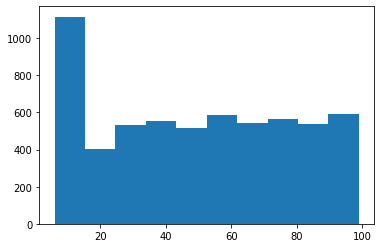

In [147]:
plt.hist(df_perc.mean(axis=1))

In [148]:
np.unique(df['Severity County 5-day'], return_counts=True)

(array([1, 2, 3]), array([2009, 1987, 1947]))

# calculating the severity index
### some important features
1. current deaths$^*$
1. forecasted deaths$^*, ^\dagger$
1. current deaths / 100k ppl$^*$
1. forecasted deaths / 100k ppl$^*, ^\dagger$
1. number ICU beds (proxy for current resources) - if we have demand info, use that instead
1. \#ICU beds / 100k ppl
1. social vulnerability index$^*$
    - includes socioeconomic status, household composition, minority status & language, housing + transportation at the county level
1. rural or urban



$^*$only available at the county-level (hospital death numbers are estimated by splitting the county-level numbers based on the number of employees at each hospital)

$\dagger$ forecasted deaths are within some window for which the model predicts well, here 5 days

### current index calculations
- "percentile" denotes replacing a value with its percentile among all values
- **severity index**: takes on values 1 (Low), 2 (Medium), 3 (High)
    - take mean of percentiles of following features: current deaths, forecasted deaths
    - sort and evenly split into 3 categories
- **surge index**
    - =$ 2 \cdot$ total predicted deaths - number ICU beds
- **rural index**: takes on values 1 (Low), 2 (Medium), 3 (High)
    - take mean of percentiles of following features **for only rural points**: current deaths, forecasted deaths, \#ICU beds / 100k ppl
    - sort and evenly split into 3 categories
    
### proposed index calculation
I think we might be able to summarize all the above with the following:
- **overall severity index**: takes on values 1 (Low), 2 (Medium), 3 (High)
    - take mean of percentiles of following features: current deaths, forecasted deaths, ($ 2 \cdot$ total predicted deaths - number ICU beds), social vulnerability index, #ICU beds / 100k ppl
    - sort and evenly split into 3 categories

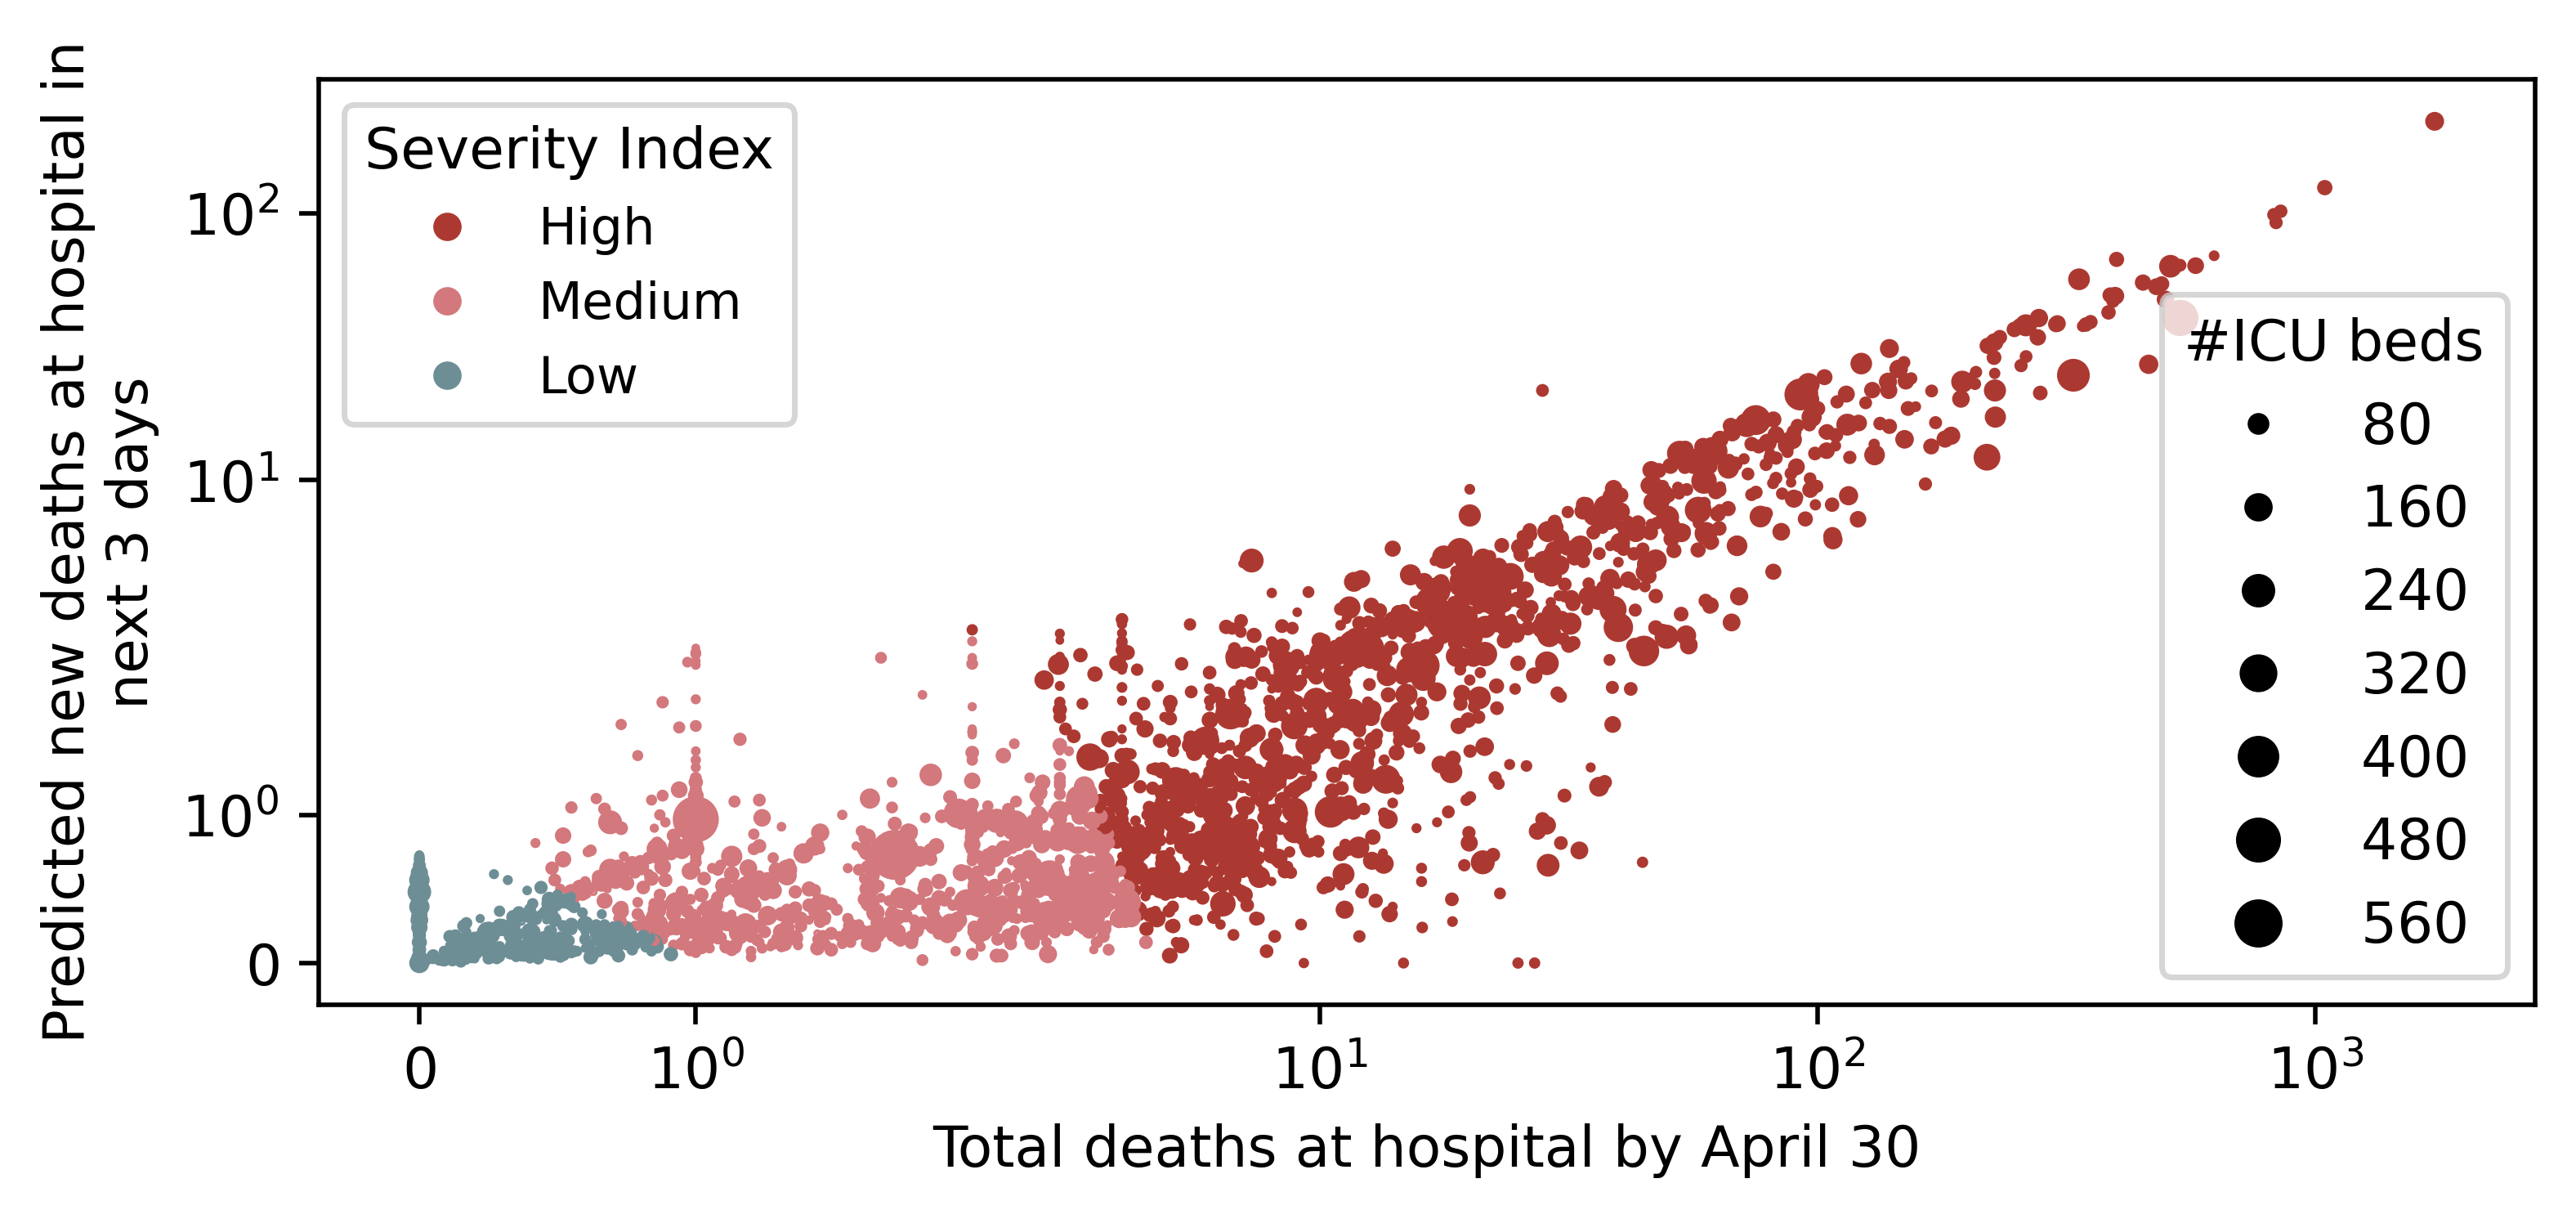

In [149]:
today = datetime.today().strftime("%B %d")
remap = {1: 'Low', 2: 'Medium', 3: 'High'}
cs_d = {i: cs[i-1] for i in [1, 2, 3]}
# cs = ['#91bfdb','#dec34b','#fc8d59']
markersize_rescaling = 10
x = d['Total Deaths Hospital']
y = d['Predicted New Deaths Hospital 3-day']
c = [cs_d[x] for x in d['Severity 3-day']] # d['Severity 3-day'] #
s = d['ICU Beds'] / markersize_rescaling
xlab = f'Total deaths at hospital by {today}'
ylab = 'Predicted new deaths at hospital in\nnext 3 days'
colorlab = 'Severity Index'
sizelab = '#ICU beds'

viz_static.plot_scatter(x, y, c, s, xlab, ylab, colorlab, sizelab, markersize_rescaling)
plt.show()

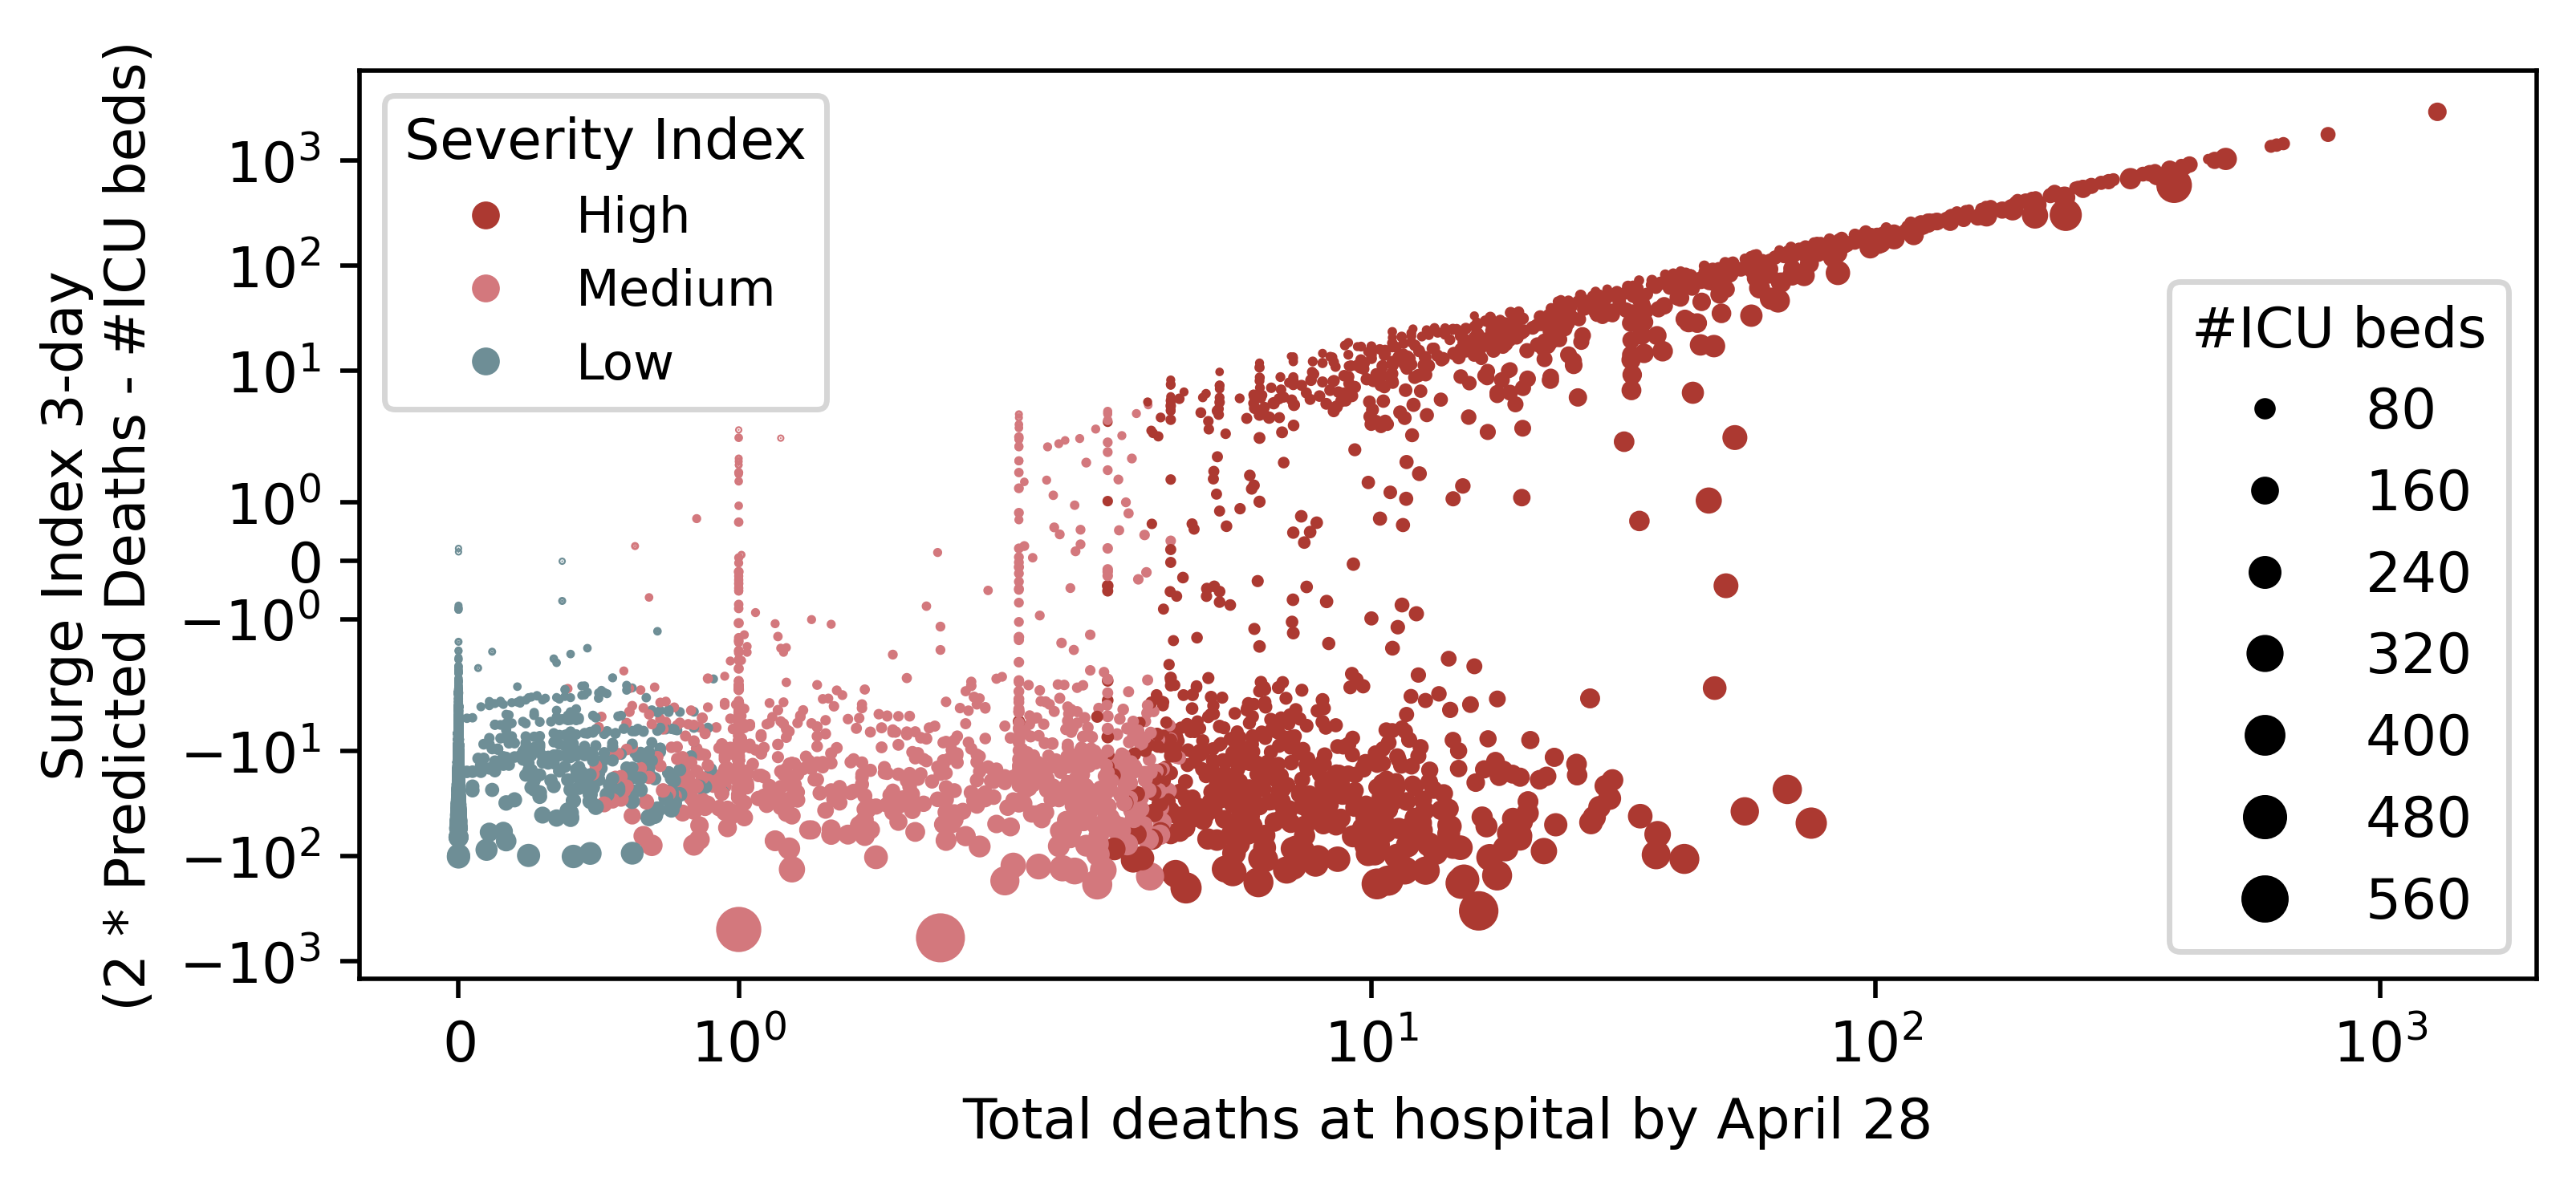

In [44]:
today = datetime.today().strftime("%B %d")
remap = {1: 'Low', 2: 'Medium', 3: 'High'}
cs_d = {i: cs[i-1] for i in [1, 2, 3]}
# cs = ['#91bfdb','#dec34b','#fc8d59']
markersize_rescaling = 10
x = d['Total Deaths Hospital']
y = d['Surge 3-day']
c = [cs_d[x] for x in d['Severity 3-day']] # d['Severity 3-day'] #
s = d['ICU Beds'] / markersize_rescaling
xlab = f'Total deaths at hospital by {today}'
ylab = 'Surge Index 3-day\n(2 * Predicted Deaths - #ICU beds)'
colorlab = 'Severity Index'
sizelab = '#ICU beds'

viz_static.plot_scatter(x, y, c, s, xlab, ylab, colorlab, sizelab, markersize_rescaling)
plt.show()

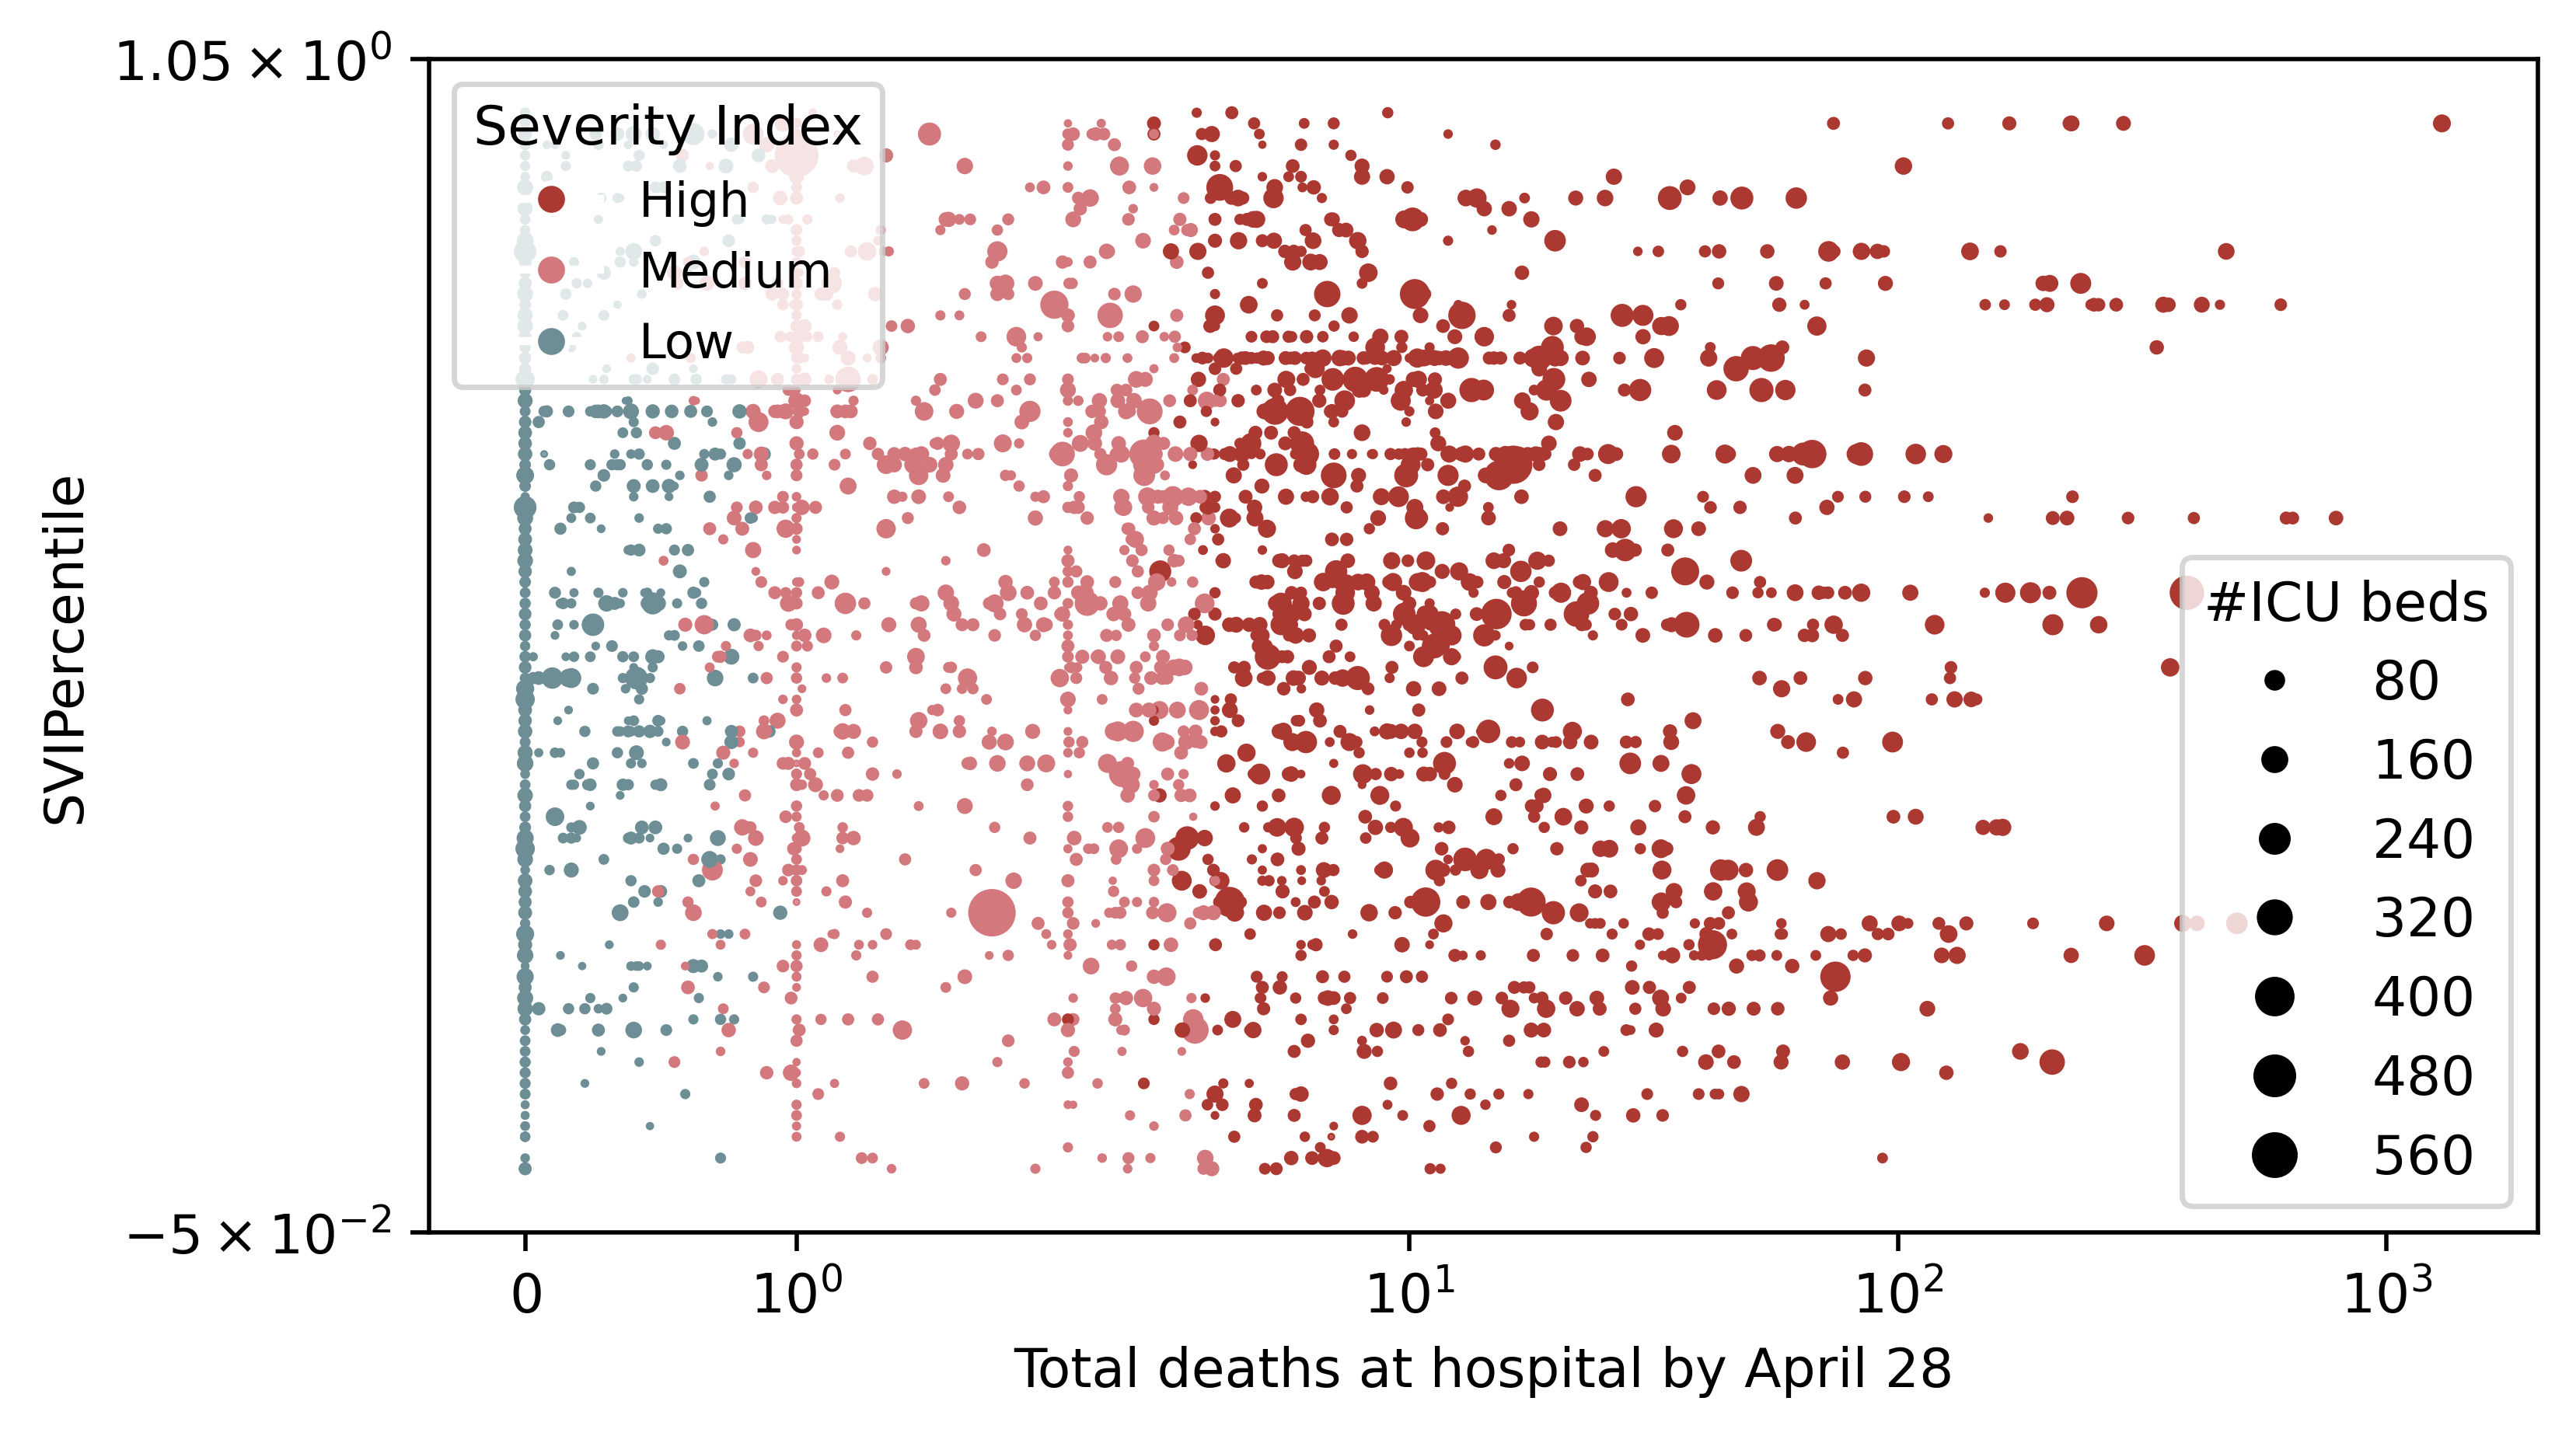

In [45]:
today = datetime.today().strftime("%B %d")
remap = {1: 'Low', 2: 'Medium', 3: 'High'}
cs_d = {i: cs[i-1] for i in [1, 2, 3]}
# cs = ['#91bfdb','#dec34b','#fc8d59']
markersize_rescaling = 10
x = d['Total Deaths Hospital']
y = d['SVIPercentile']
c = [cs_d[x] for x in d['Severity 3-day']] # d['Severity 3-day'] #
s = d['ICU Beds'] / markersize_rescaling
xlab = f'Total deaths at hospital by {today}'
ylab = 'SVIPercentile'
colorlab = 'Severity Index'
sizelab = '#ICU beds'

viz_static.plot_scatter(x, y, c, s, xlab, ylab, colorlab,
                        sizelab, markersize_rescaling, figsize=(7, 4))
plt.show()

# adjustments

**different measures of hospital size are pretty consistent**

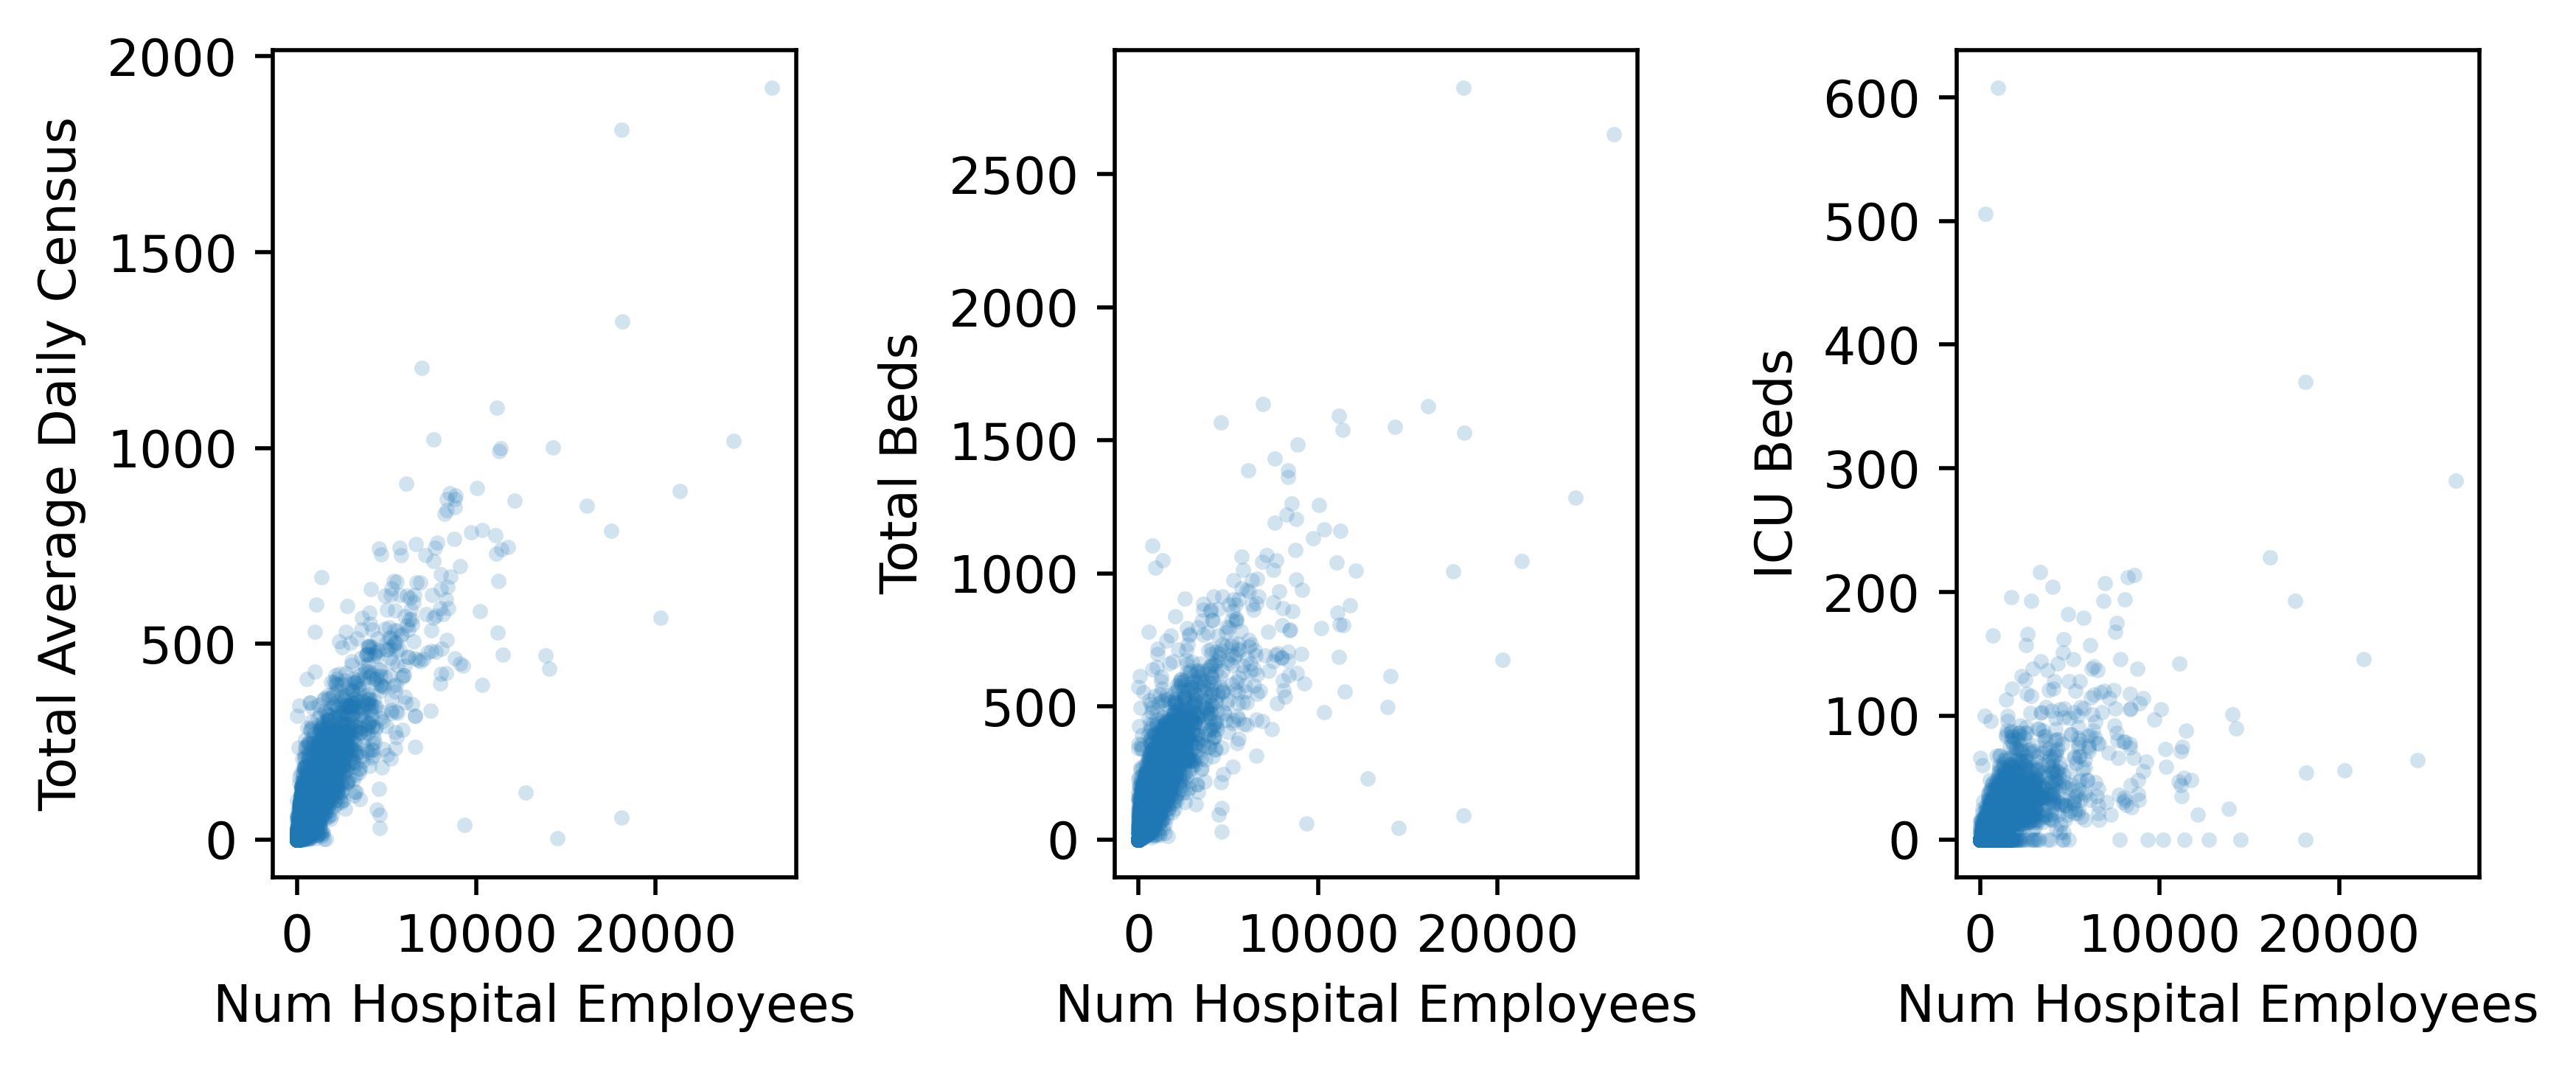

In [11]:
plt.figure(dpi=500, figsize=(7, 3), facecolor='w')
R, C = 1, 3
plt.subplot(R, C, 1)
plt.plot(df['Hospital Employees'], df['Total Average Daily Census'], '.', alpha=0.2, markeredgewidth=0)
plt.xlabel('Num Hospital Employees')
plt.ylabel('Total Average Daily Census')

plt.subplot(R, C, 2)
plt.plot(df['Hospital Employees'], df['Total Beds'], '.', alpha=0.2, markeredgewidth=0)
plt.xlabel('Num Hospital Employees')
plt.ylabel('Total Beds')

plt.subplot(R, C, 3)
plt.plot(df['Hospital Employees'], df['ICU Beds'], '.', alpha=0.2, markeredgewidth=0)
plt.xlabel('Num Hospital Employees')
plt.ylabel('ICU Beds')

plt.tight_layout()
plt.show()

**other measures are harder to parse...**

In [ ]:
ks = ['Predicted Deaths Hospital 2-day', "Hospital Employees", 'ICU Beds']
R, C = 1, len(ks)
plt.figure(dpi=300, figsize=(C * 3, R * 3))

for c in range(C):
    plt.subplot(R, C, c + 1)
    if c == 0:
        plt.ylabel('Total Occupancy Rate')
    plt.plot(df[ks[c]], df['Total Occupancy Rate'], '.', alpha=0.5)
    plt.xlabel(ks[c])

plt.tight_layout()
plt.show()

**different hospital types**

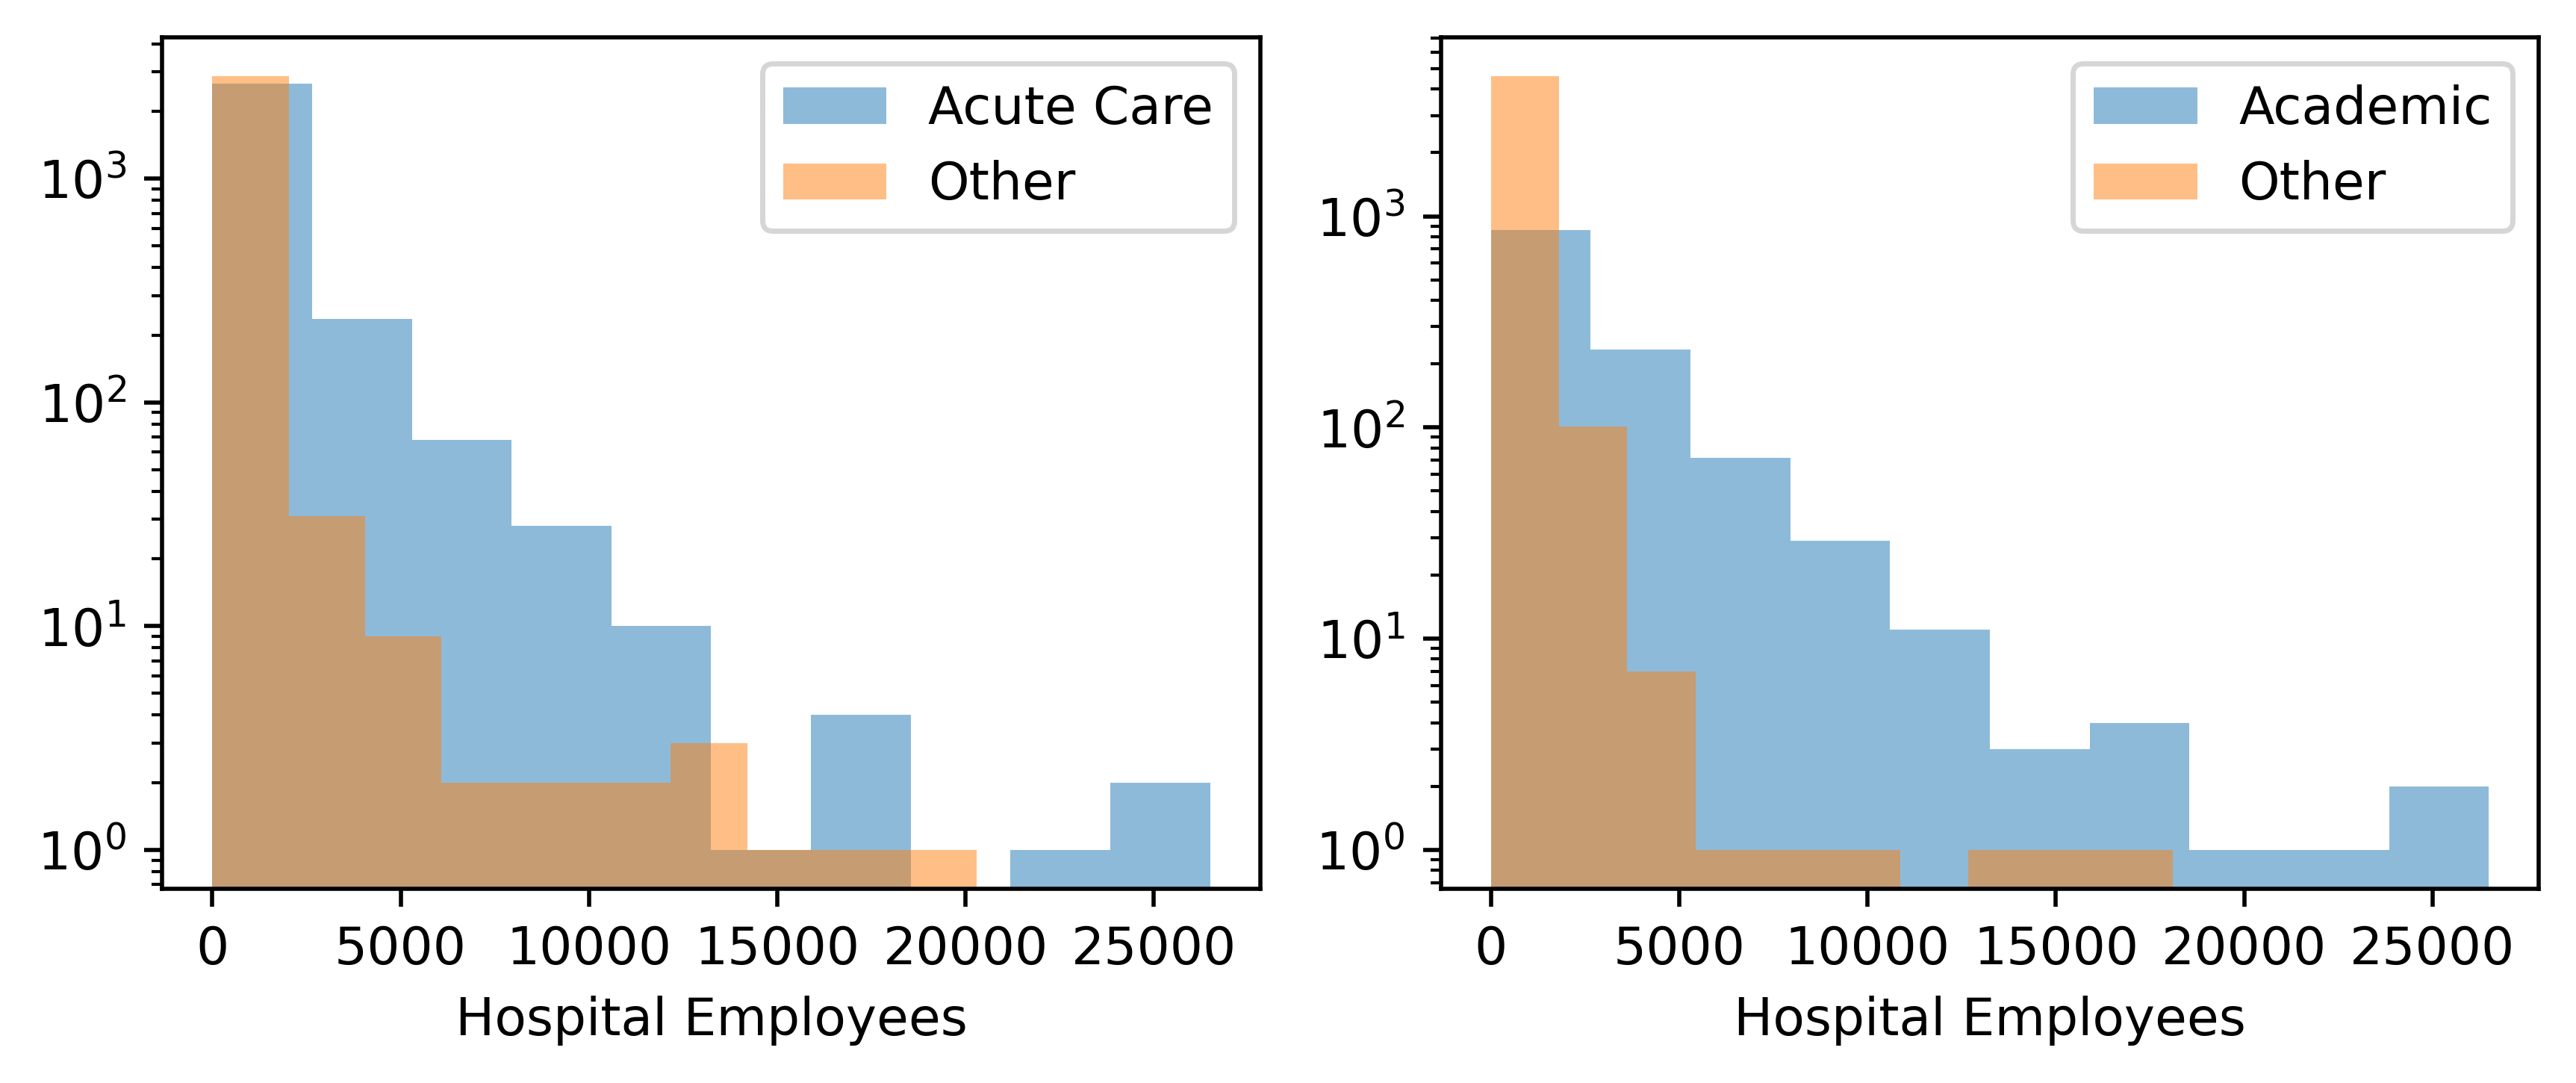

In [10]:
plt.figure(dpi=500, figsize=(7, 3))
R, C = 1, 2
a = 0.5
s = 'Hospital Employees'

plt.subplot(R, C, 1)
idxs = df.IsAcuteCareHospital == 1
plt.hist(df[idxs][s], label='Acute Care', alpha=a)
plt.hist(df[~idxs][s], label='Other', alpha=a)
plt.xlabel(s)
plt.yscale('log')
plt.legend()

plt.subplot(R, C, 2)
idxs = df.IsAcademicHospital == 1
plt.hist(df[idxs][s], label='Academic', alpha=a)
plt.hist(df[~idxs][s], label='Other', alpha=a)
plt.xlabel(s)
plt.yscale('log')

plt.legend()
plt.tight_layout()
plt.show()

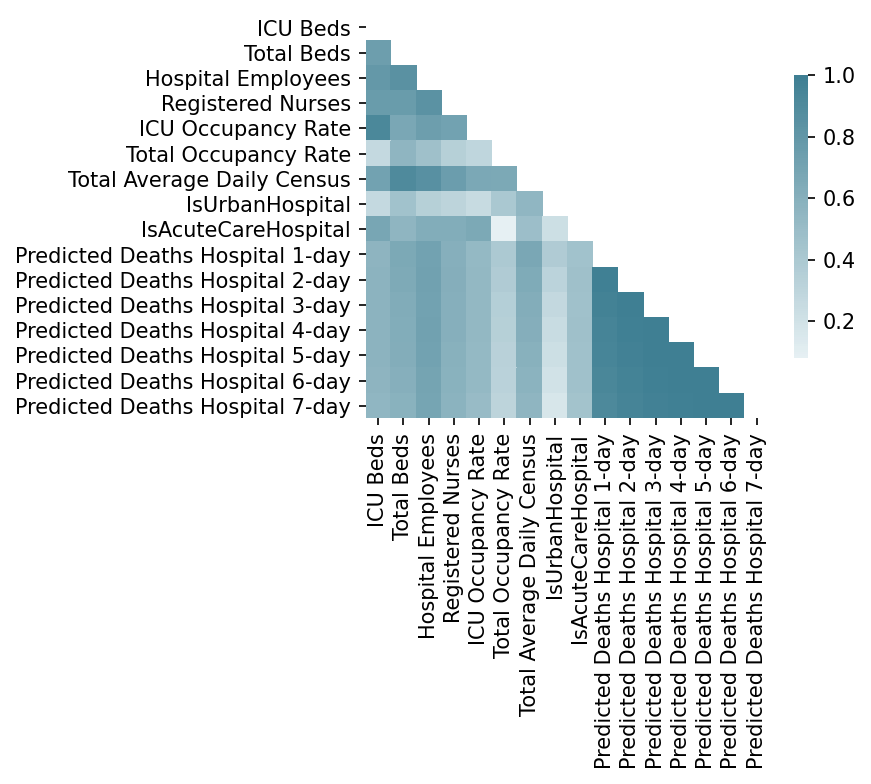

In [16]:
ks = ['ICU Beds', 'Total Beds', 
      'Hospital Employees', 'Registered Nurses',
      'ICU Occupancy Rate', 'Total Occupancy Rate',
      'Mortality national comparison', 'Total Average Daily Census',
      
#       'IsAcademicHospital', 
      'IsUrbanHospital', 'IsAcuteCareHospital']
      
      

# ks += [f'Predicted Deaths {n}-day' for n in NUM_DAYS_LIST]
ks += [f'Predicted Deaths Hospital {n}-day' for n in NUM_DAYS_LIST]

# county-level stuff
# ks += ['unacast_n_grade', Hospital Employees in County', 'tot_deaths', 'tot_cases', 'PopulationDensityperSqMile2010'] 


viz_static.corrplot(df[ks], SIZE=6)

# understand rural areas

3366 urban hospitals, 2577 rural


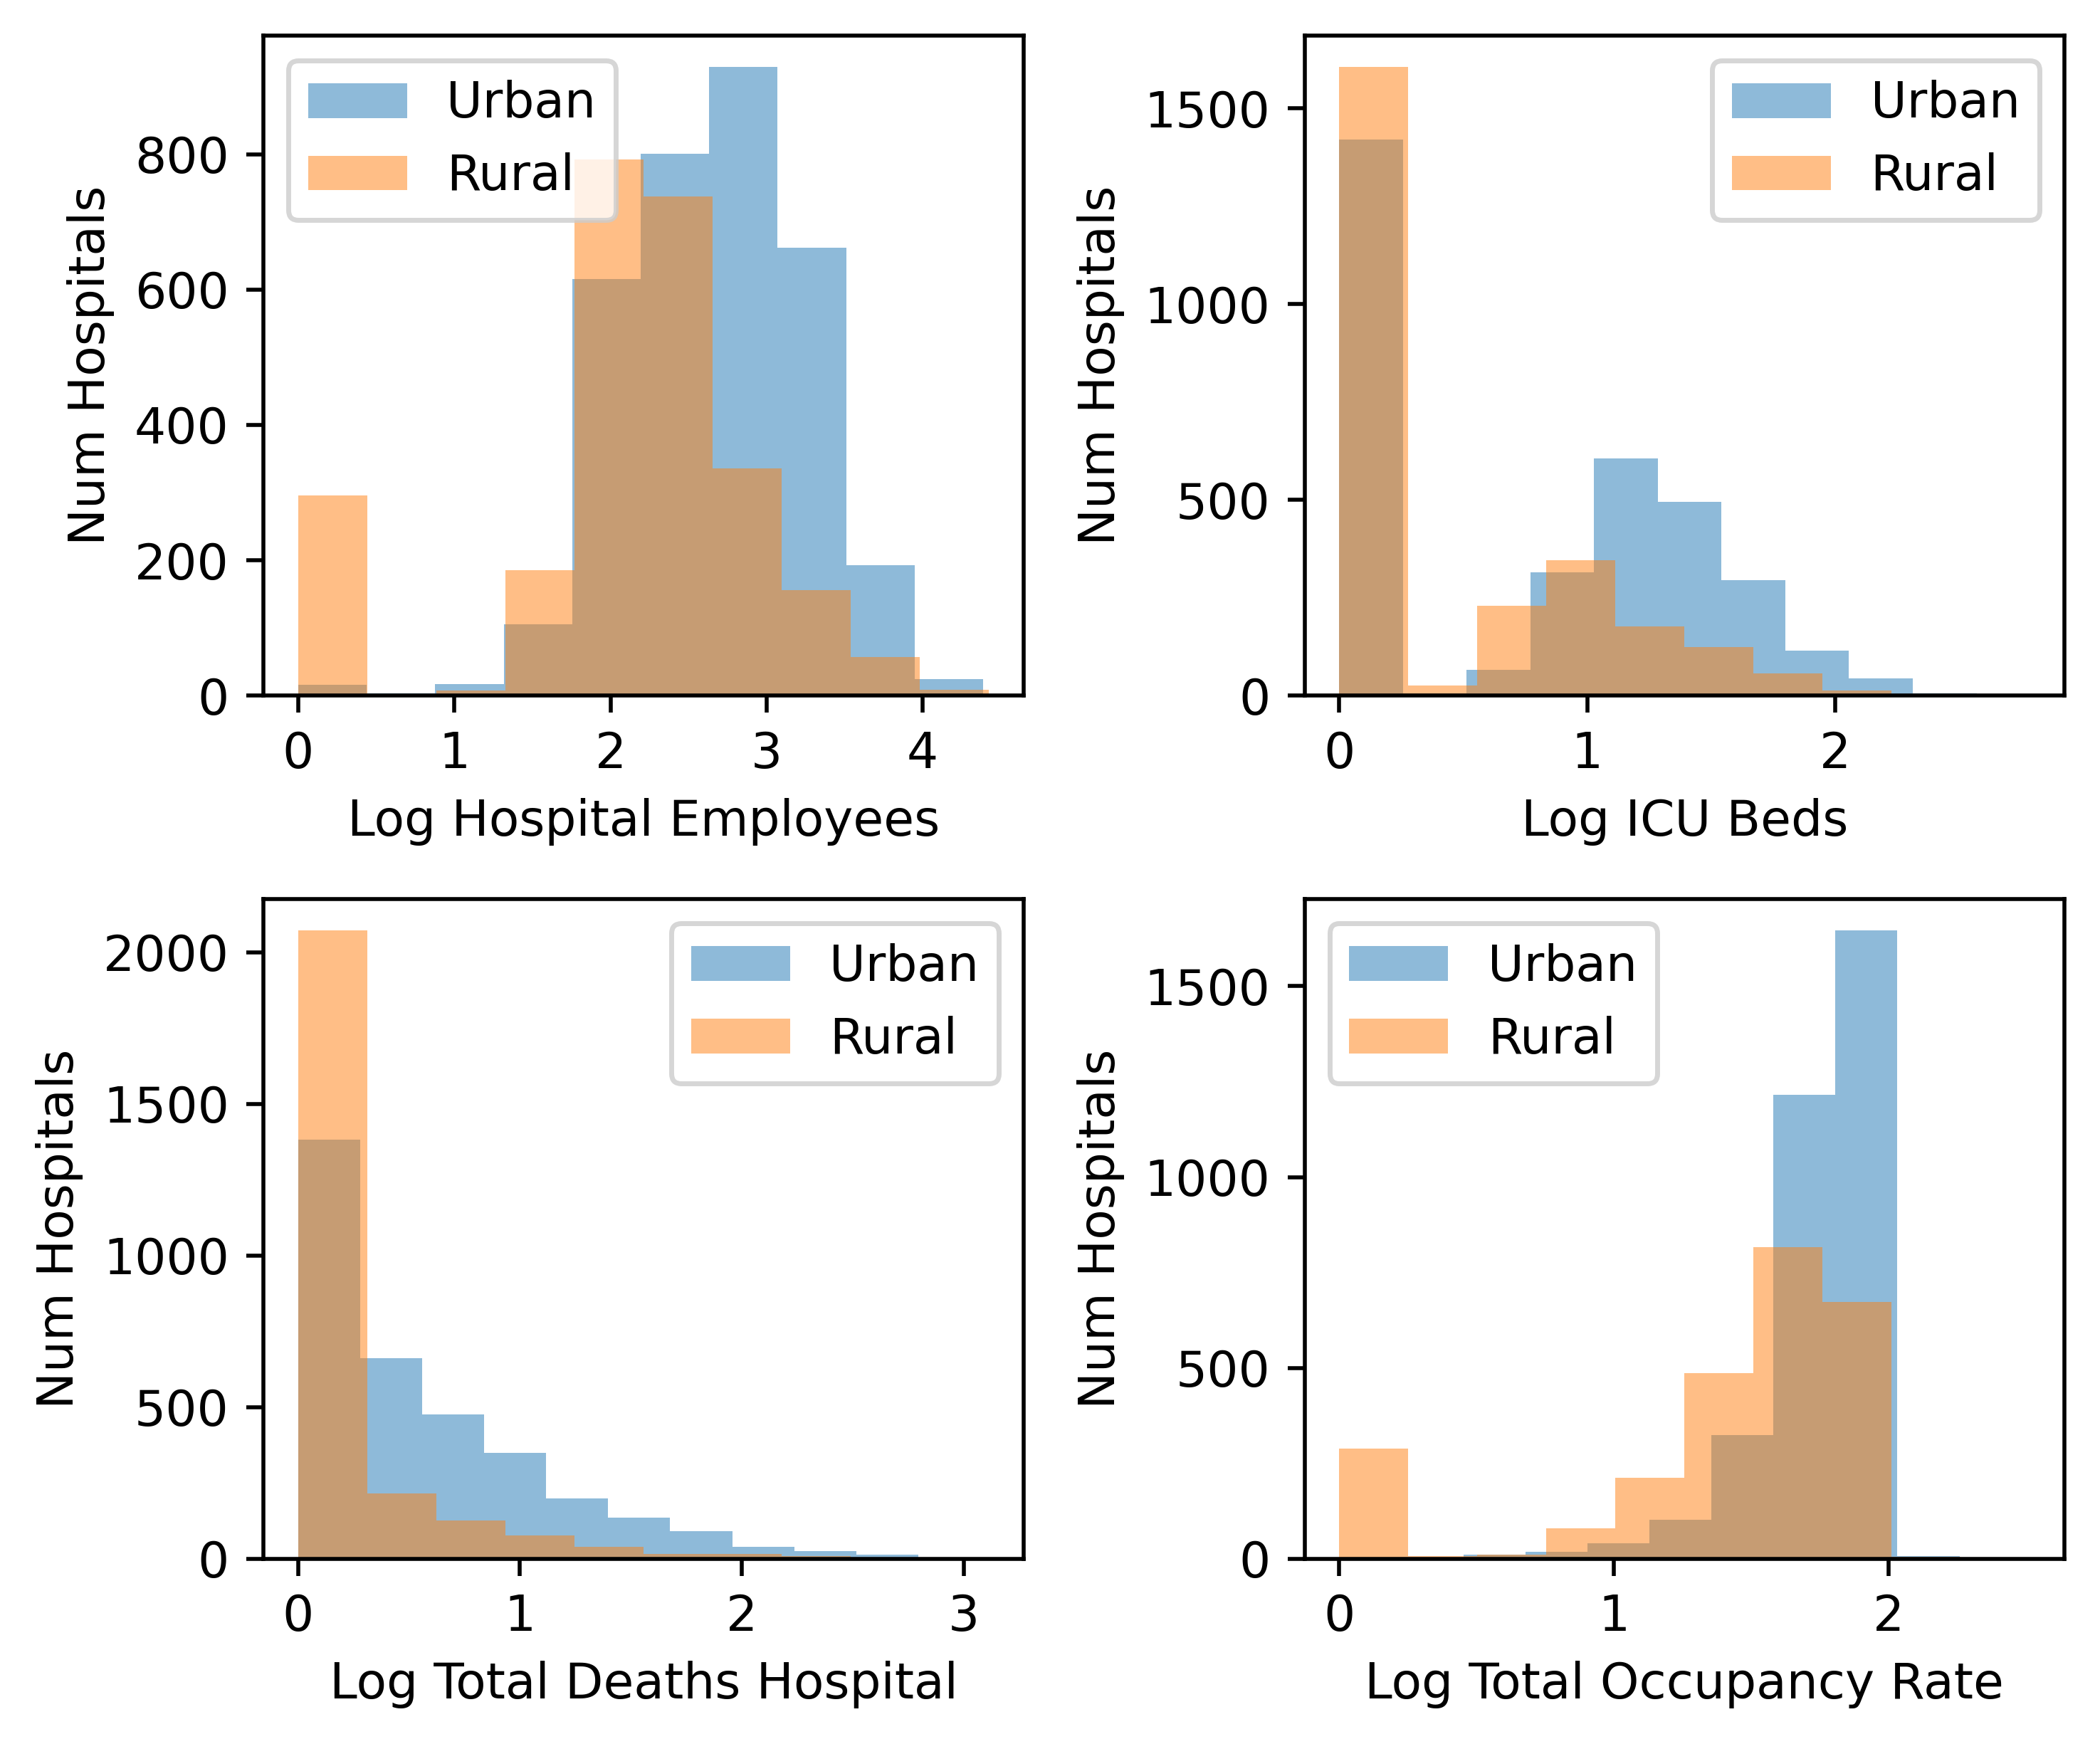

In [9]:
plt.figure(dpi=500, figsize=(6, 5))
R, C = 2, 2
a = 0.5

idxs = df['Urban or Rural Designation'] == 'Urban'
urb = df[idxs]
rur = df[~idxs]

print(f'{urb.shape[0]} urban hospitals, {rur.shape[0]} rural')
for i, s in enumerate(['Hospital Employees', 'ICU Beds', 'Total Deaths Hospital', 'Total Occupancy Rate']):
    plt.subplot(R, C, i + 1)
    plt.ylabel('Num Hospitals')
    plt.xlabel('Log ' + s)
#     plt.xscale('log')
#     plt.yscale('log')
    plt.hist(np.log10(urb[s] + 1), label='Urban', alpha=a)
    plt.hist(np.log10(rur[s] + 1), label='Rural', alpha=a)
    plt.legend()


plt.tight_layout()
plt.show()

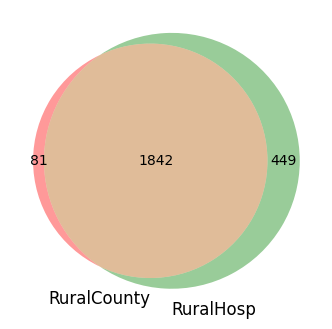

In [7]:
df['RuralCounty'] = df['Rural-UrbanContinuumCode2013'] > 3
df['RuralHosp'] = df['Urban or Rural Designation'] == 'Rural'
ids = df.index[df['RuralCounty']]
ids2 = df.index[df['RuralHosp']]
plt.figure(dpi=100)
venn2([set(ids), set(ids2)], set_labels=['RuralCounty', 'RuralHosp'])

In [ ]:
[k for k in df.keys() if 'pop' in k.lower()]

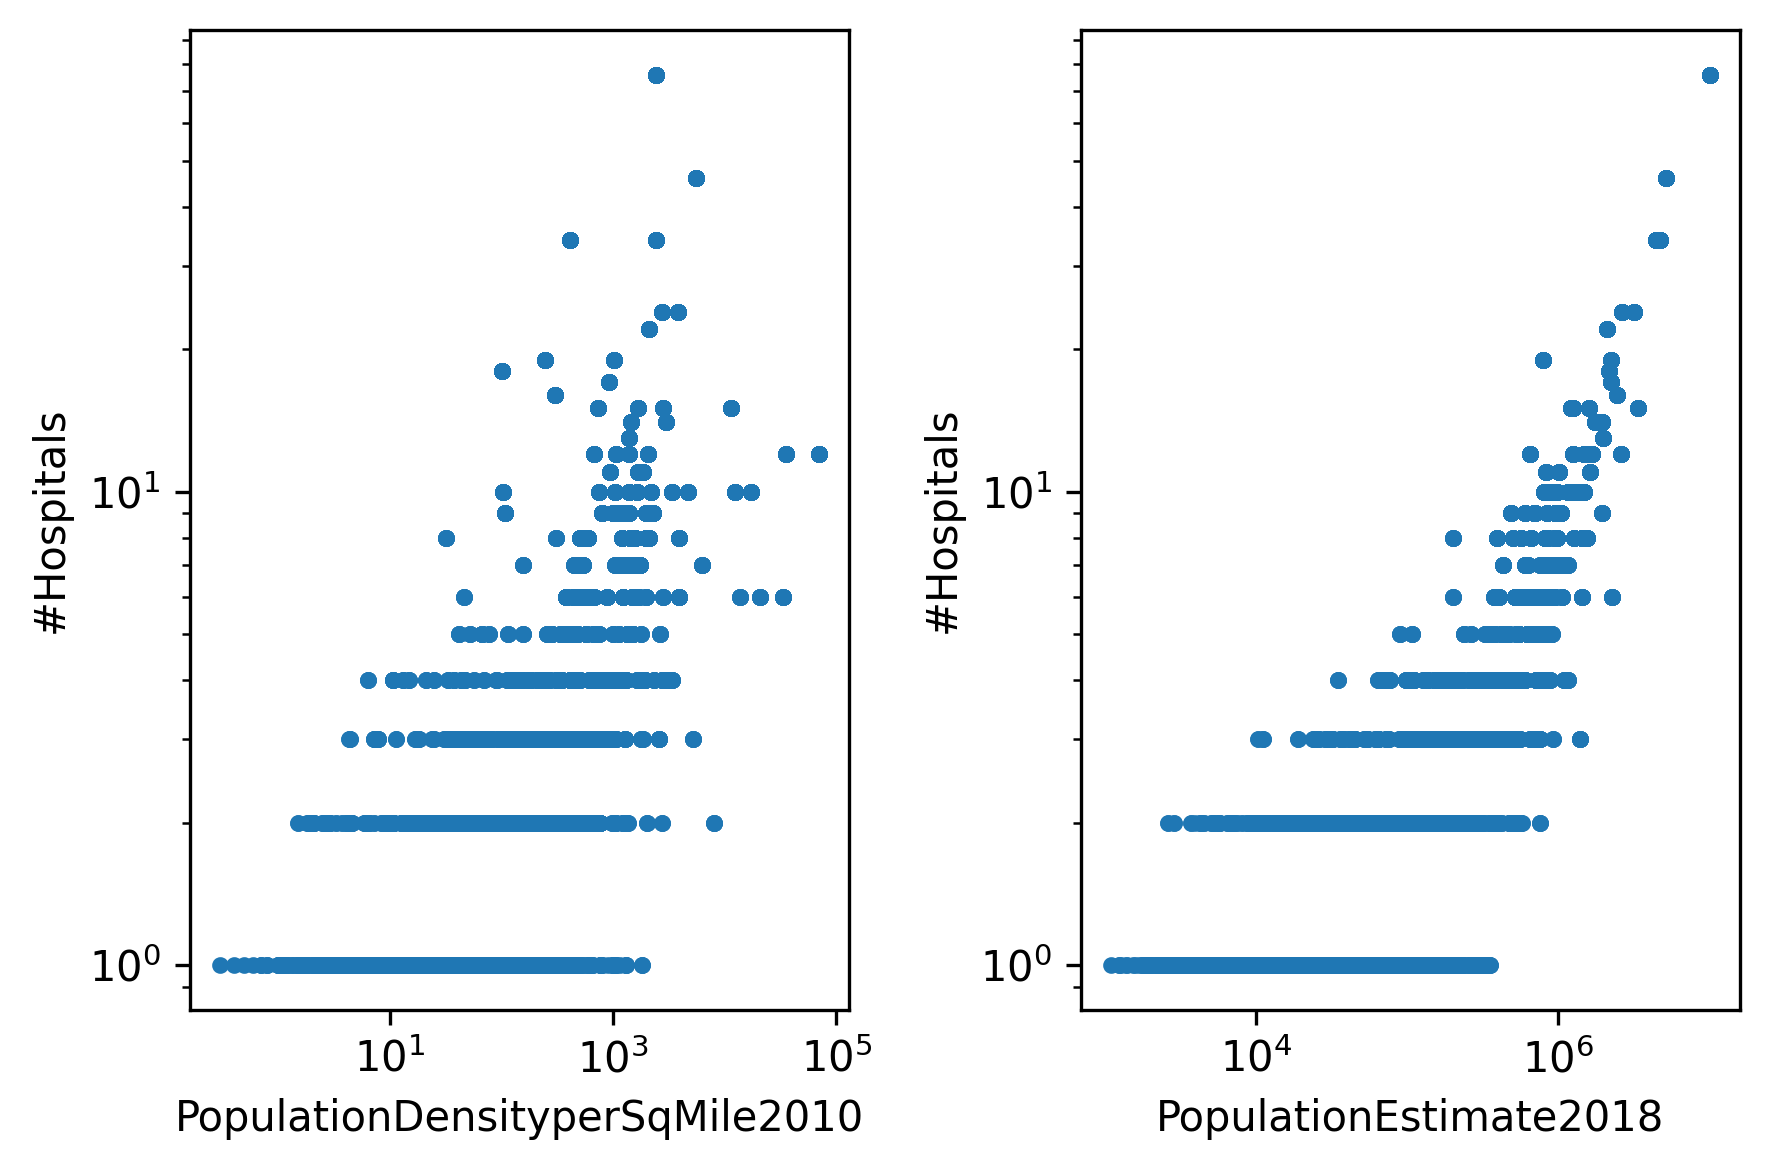

In [111]:
def plot(x, y):
    plt.loglog(df[x], df[y], '.')
    plt.xlabel(x)
    plt.ylabel(y)
    
plt.figure(dpi=300)
R, C = 1, 2
plt.subplot(R, C, 1)
plot('PopulationDensityperSqMile2010', '#Hospitals')
plt.subplot(R, C, 2)

plot('PopulationEstimate2018', '#Hospitals')
plt.tight_layout()

num hospitals with 0 ICU beds: 36
num hospitals with 1 ICU beds: 1823
num hospitals with 2 ICU beds: 1070
num hospitals with 3 ICU beds: 617
num hospitals with 4 ICU beds: 444


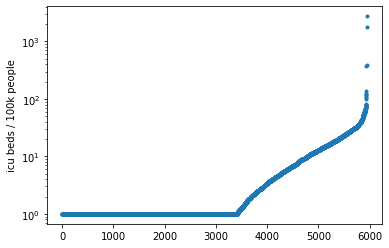

In [112]:
vals = (df['ICU Beds'].fillna(0) / (df['PopulationEstimate2018'] / 1e5)).values
vals = np.clip(np.sort(vals), a_min=1, a_max=None)
plt.yscale('log')
plt.plot(vals, '.')
plt.ylabel('icu beds / 100k people')
for i in range(5):
    print(f'num hospitals with {i} ICU beds: {(df["#Hospitals"]==i).sum()}')

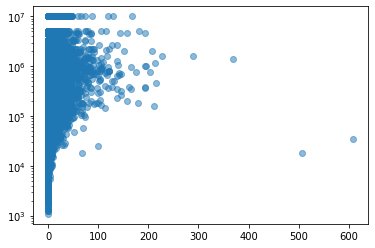

In [113]:
plt.plot(df['ICU Beds'], df['PopulationEstimate2018'], 'o', alpha=0.5)
plt.yscale('log')